In [29]:
# Nessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

# Save file
results_file = './write/csanz-raw.h5ad'

# Open project
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

# Imported from fpkm table
adata = sc.read("csanz2018-raw.h5ad")
adata

scanpy==1.2.2 anndata==0.6.4 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


AnnData object with n_obs × n_vars = 1108 × 16862 
    obs: 'n_genes', 'n_counts', 'orig_ident', 'marker', 'prep_date', 'sort_date', 'percent_mito', 'S_Score', 'G2M_Score', 'Phase', 'old_ident', 'CC_Seurat', 'res_1', 'MergedGFP'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled'
    obsm: 'X_pca', 'X_tsne', 'X_tsne3d'

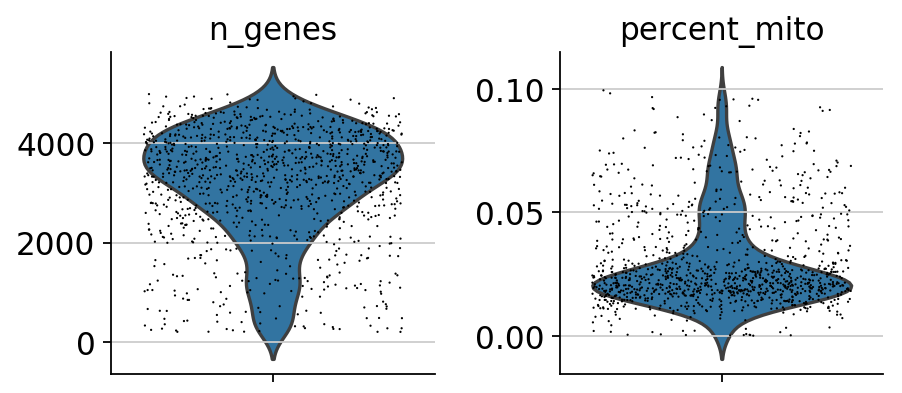

In [30]:
sc.pl.violin(adata, ['n_genes', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [31]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [32]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
    finished (0:00:01.21)


In [33]:
sc.tl.pca(adata)
sc.pp.pca(adata)

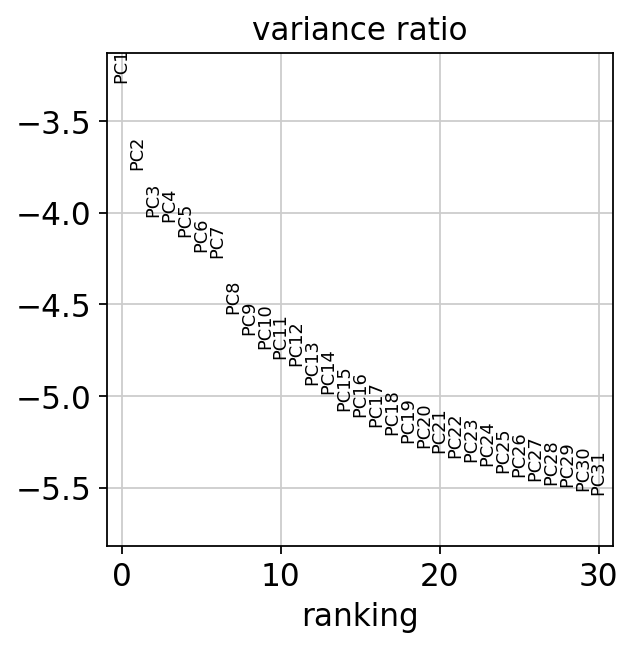

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [91]:
# Adjusted to 30 PC's - better results
sc.pp.neighbors(adata, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:00.32) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [92]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03.10) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [93]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.07) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [94]:
sc.tl.paga(adata)

running partition-based graph abstraction (PAGA)
    finished (0:00:00.03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


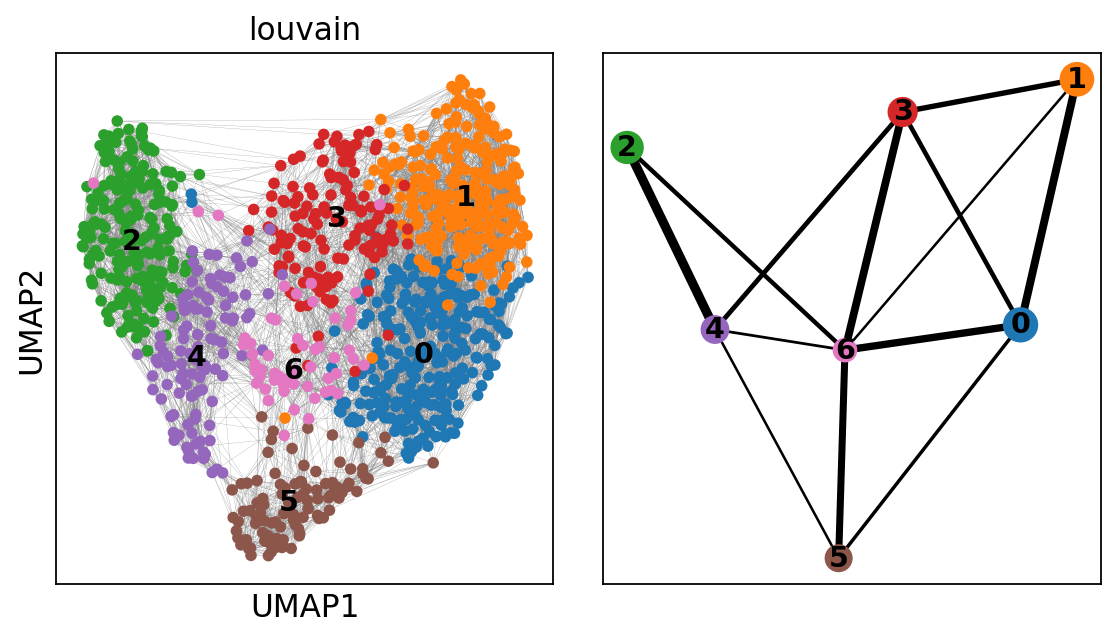

In [102]:
sc.pl.paga_compare(adata, threshold=0.15, basis='umap')

In [96]:
gene_names = ['Vim','Eomes','Hes6','Neurod6']

saving figure to file ./figures/violin.pdf


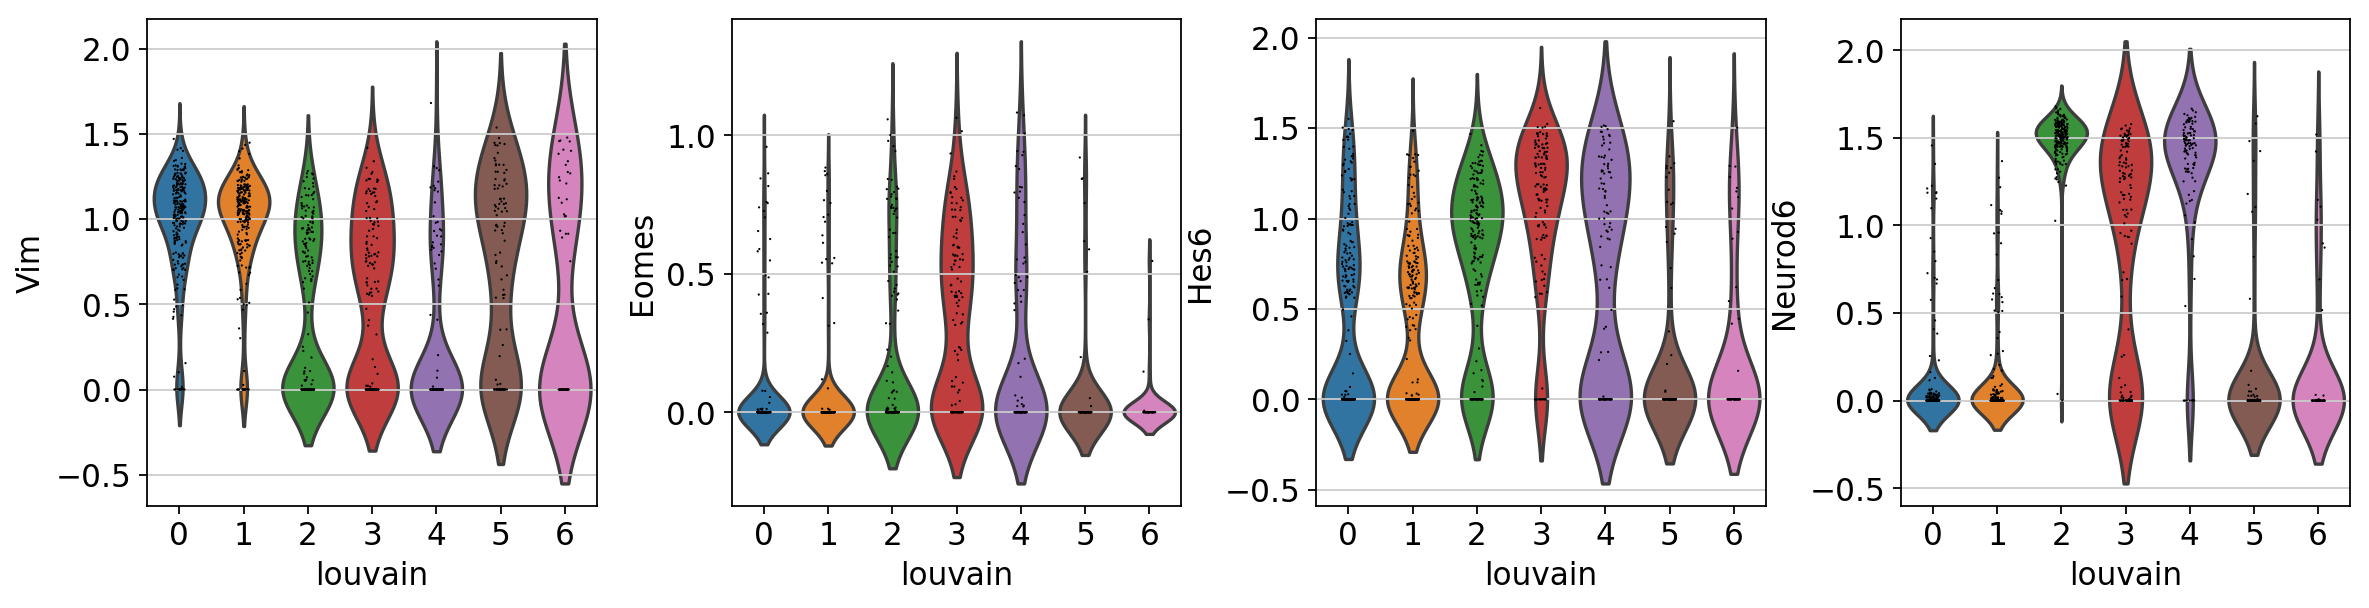

In [97]:
sc.pl.violin(adata, gene_names, groupby="louvain", save=True)

--> added 'pos', the PAGA positions (adata.uns['paga'])


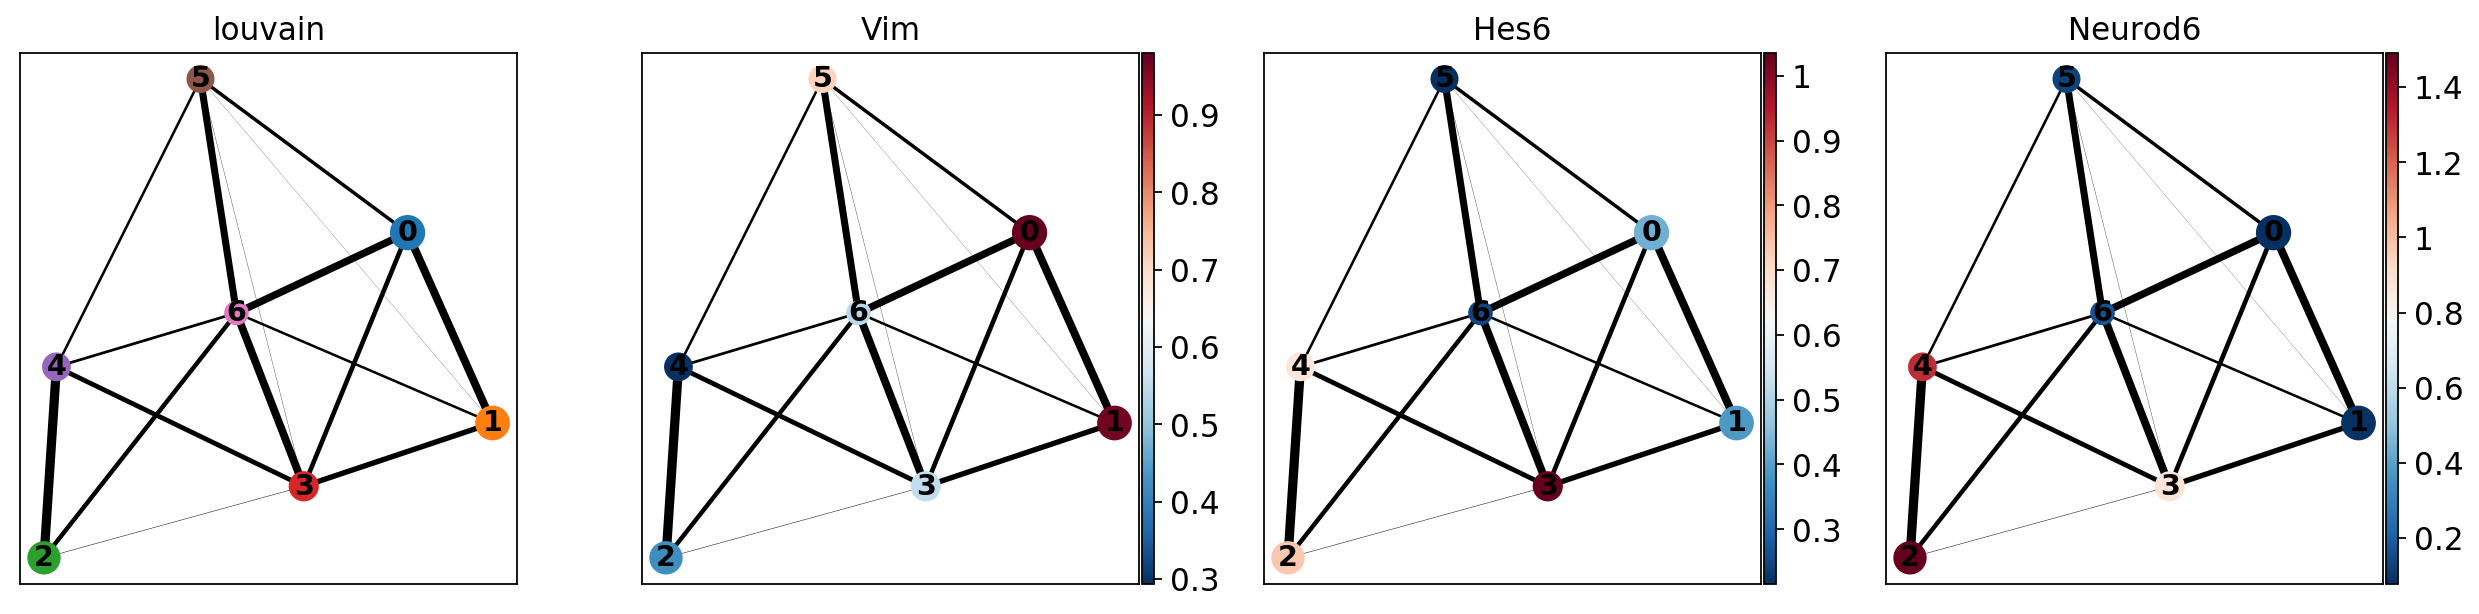

In [128]:
sc.pl.paga(adata, color=['louvain', 'Vim', 'Hes6', 'Neurod6'])

In [25]:
adata.write(results_file)

ranking genes
    finished (0:00:00.49) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
saving figure to file ./figures/rank_genes_groups_louvain.pdf


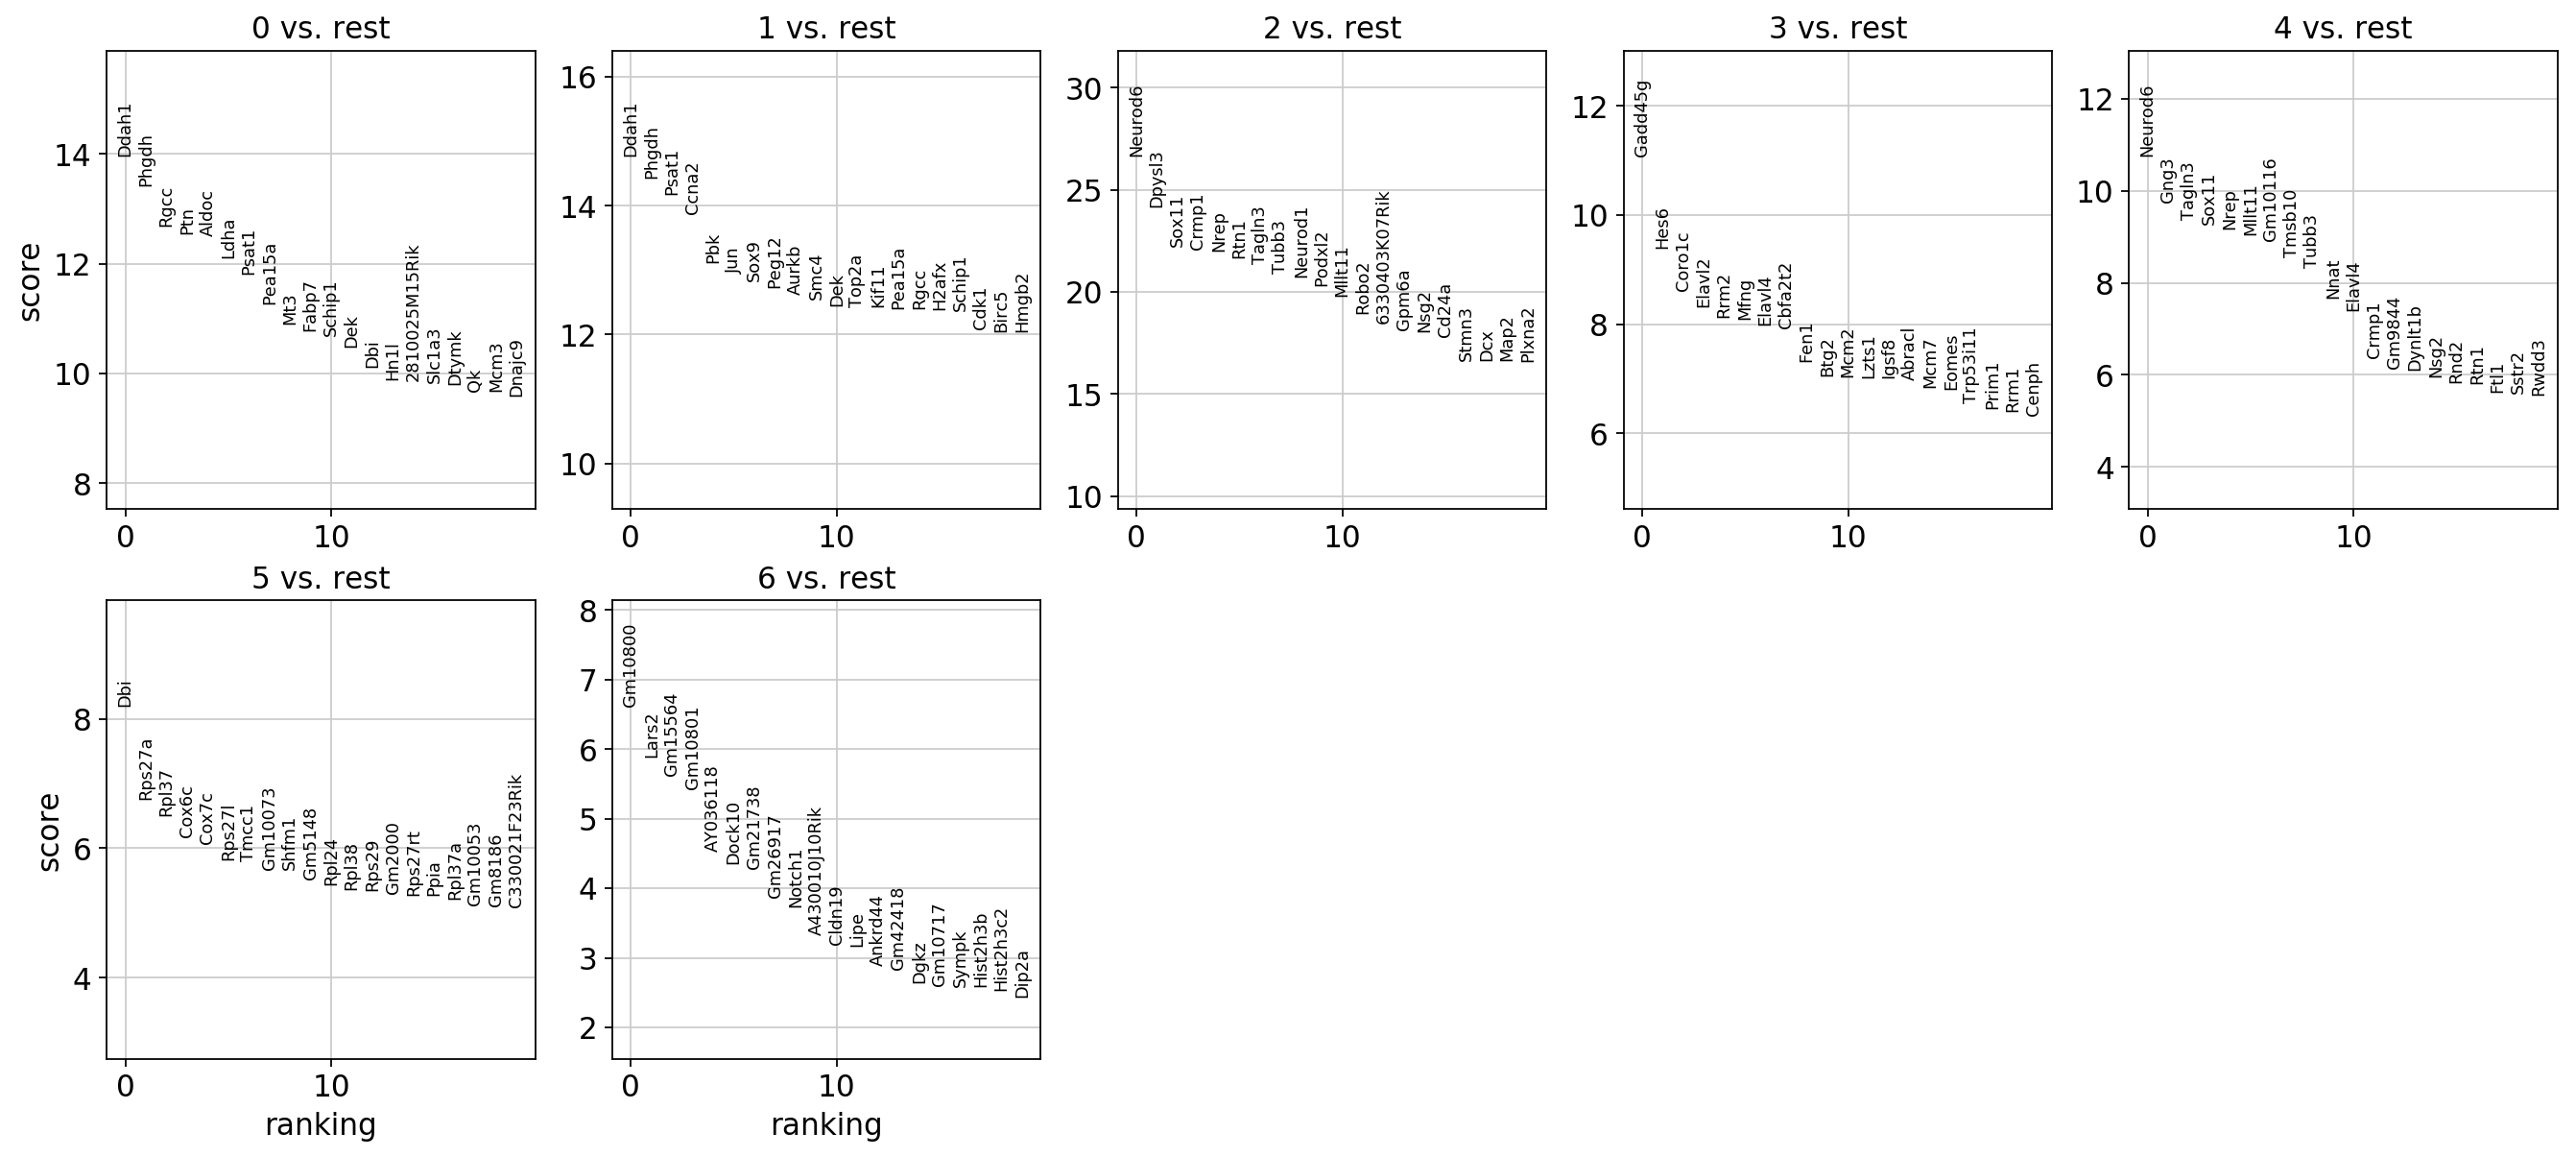

In [124]:
# Find markers
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, save='.pdf')
adata.write(results_file)

In [105]:
# Plot using Fruchterman-Reingold algorithm
sc.tl.draw_graph(adata)

drawing single-cell graph using layout "fa"
    finished (0:00:04.62) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


saving figure to file ./figures/draw_graph_fa.pdf


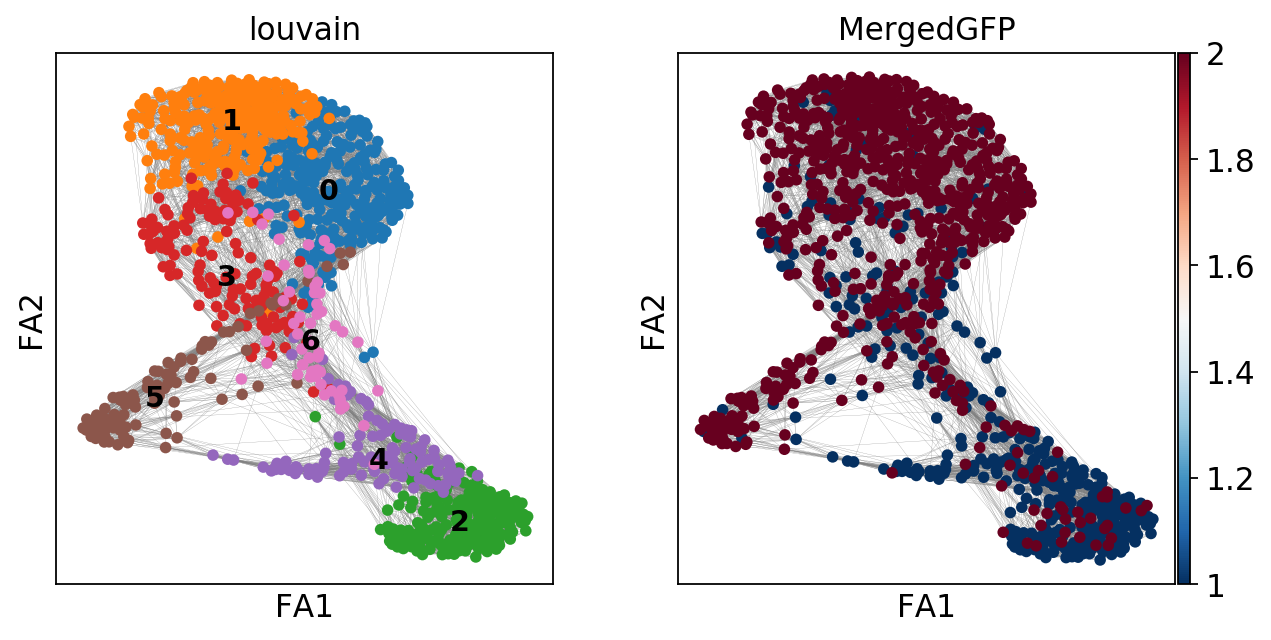

In [151]:
# Louvain clusters and GFP+ marker
# Obs: Red = Hes5-eGFP+ and Blue = CAG-mRFP+
sc.pl.draw_graph(
    adata, color=['louvain','MergedGFP'],
    legend_loc='on data',
    edges=True,
    save=True)

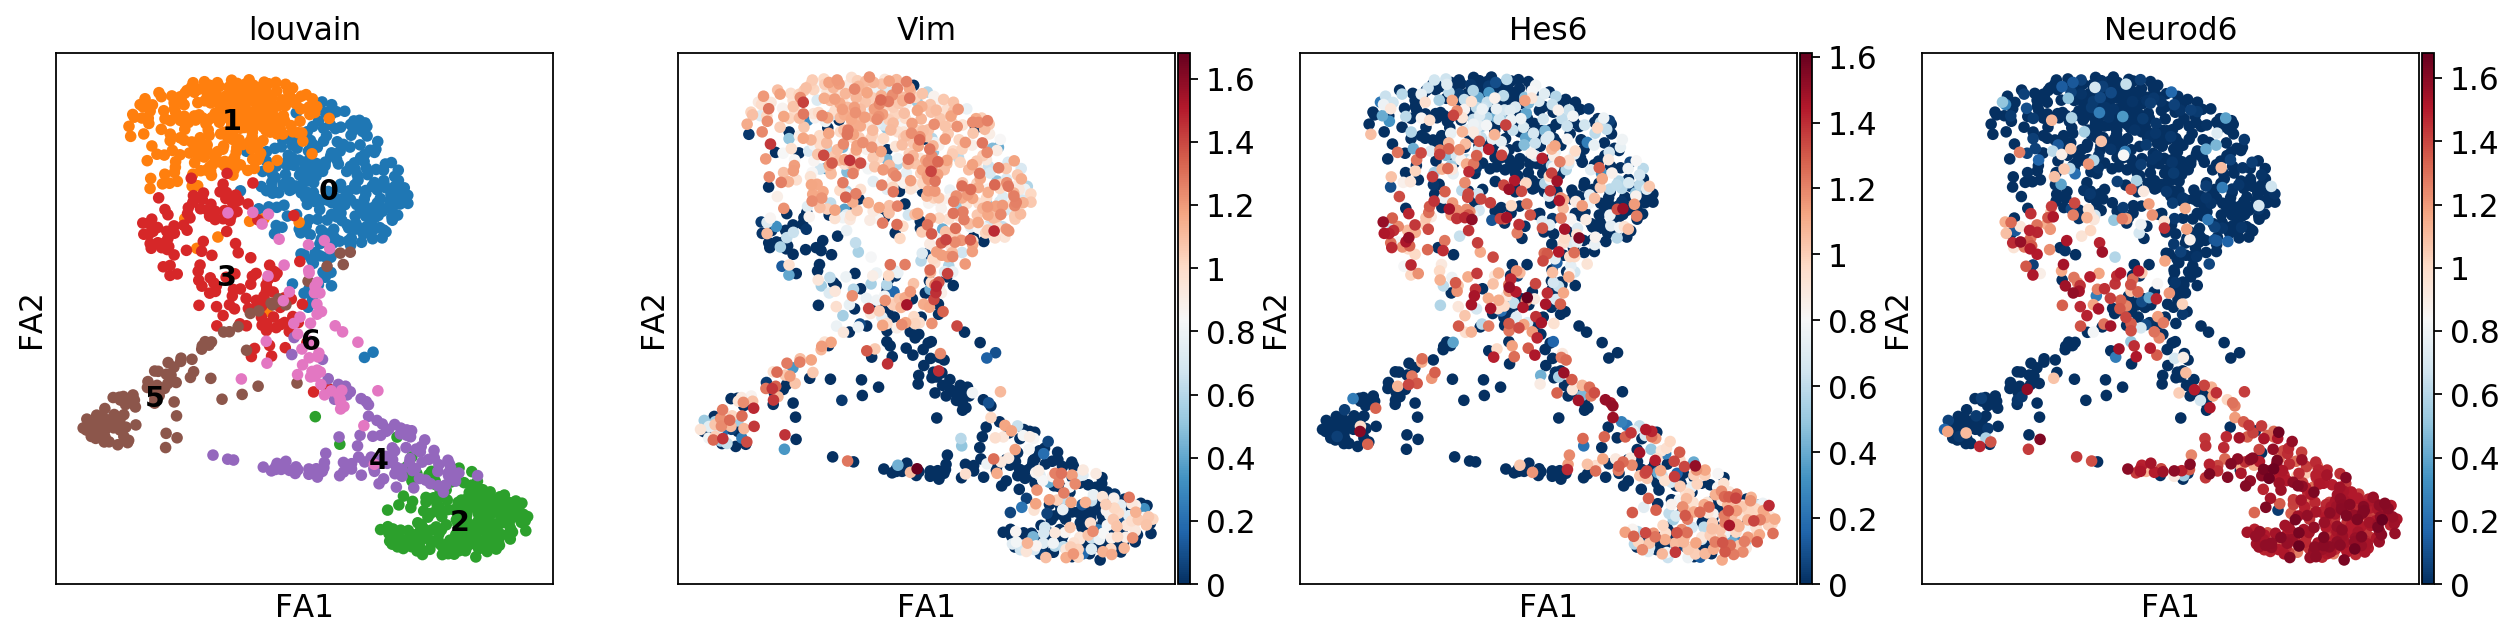

In [152]:
# Benchmark genes
sc.pl.draw_graph(adata, color=['louvain', 'Vim', 'Hes6', 'Neurod6'], legend_loc='on data', )

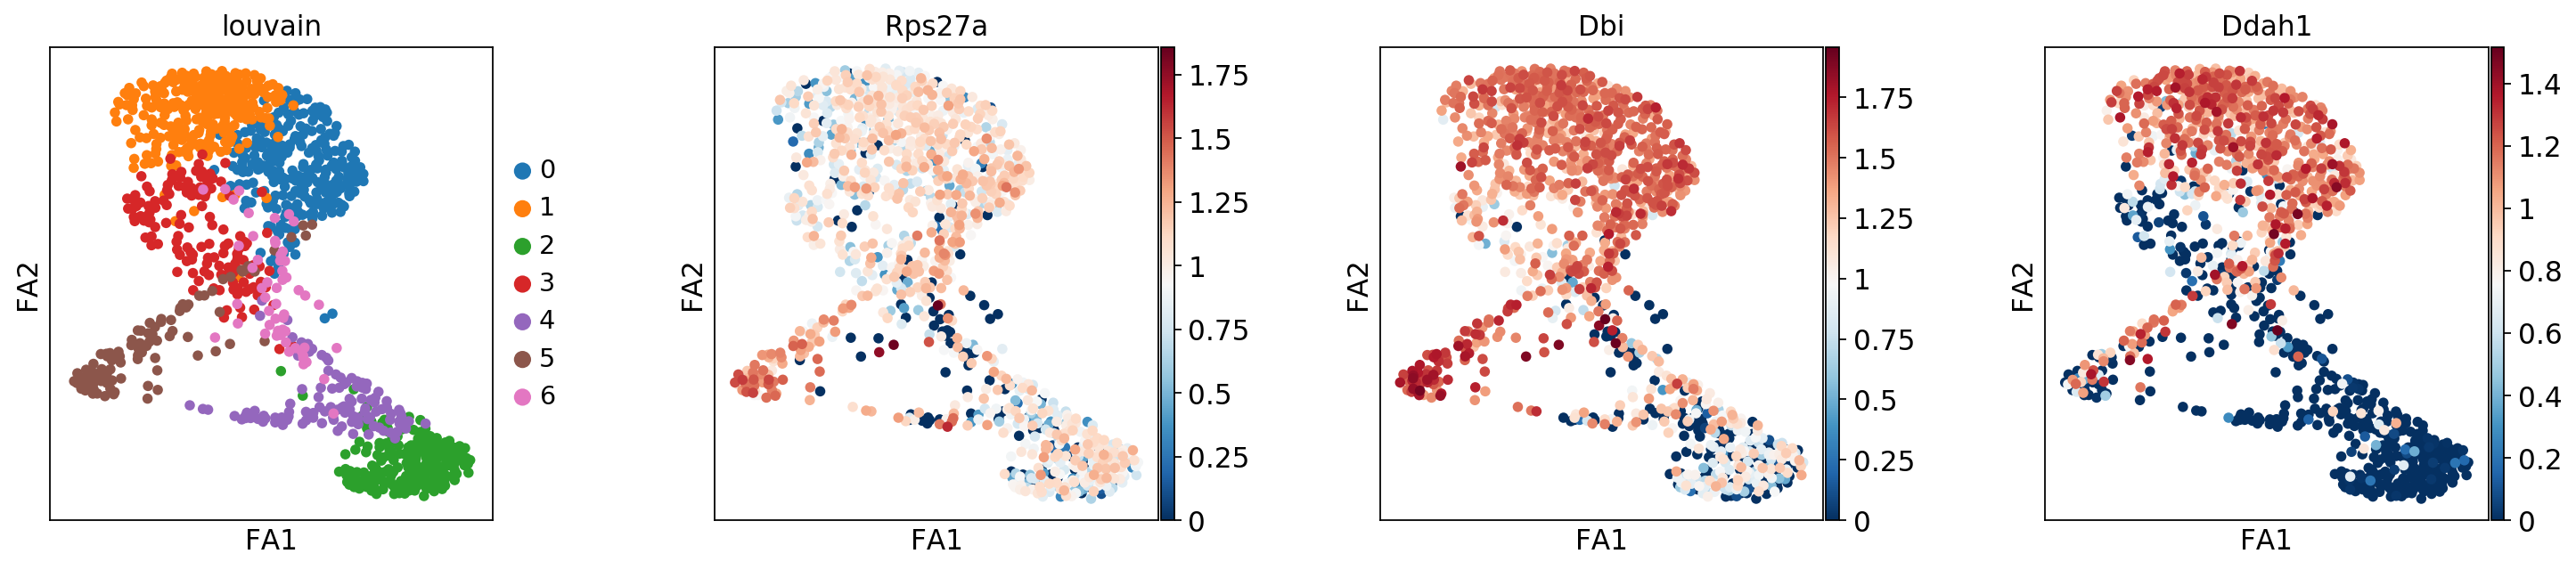

In [153]:
# Genes related to cluster 5
sc.pl.draw_graph(adata, color=['louvain','Rps27a','Dbi','Ddah1'])

running partition-based graph abstraction (PAGA)
    finished (0:00:00.03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


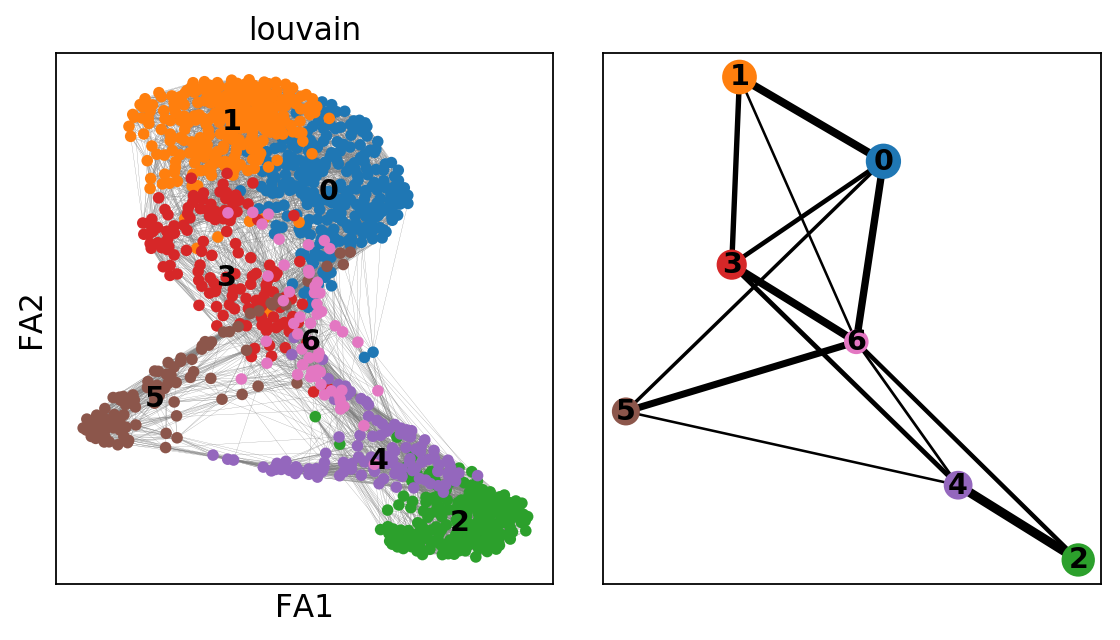

In [110]:
# PAGA
sc.tl.paga(adata)
sc.pl.paga_compare(
    adata, basis='X_draw_graph_fr', layout='rt', threshold_solid=0.5)

In [112]:
adata.write(results_file)

In [135]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain']  == '1')[0]

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9803646  0.9650849  0.9228627  0.9158642  0.907607
     0.8638276  0.8529824  0.8378915  0.8276346  0.81680894 0.8099421
     0.800098   0.7994146  0.7834221 ]
    finished (0:00:00.09) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


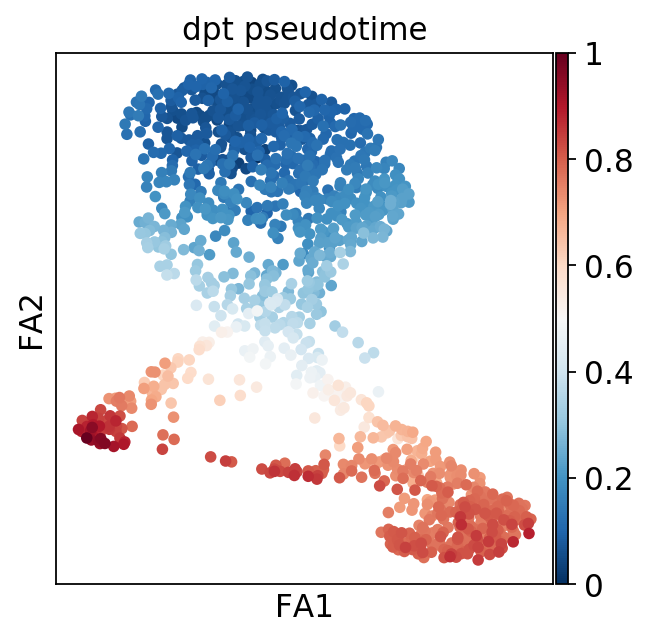

In [136]:
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color='dpt_pseudotime')

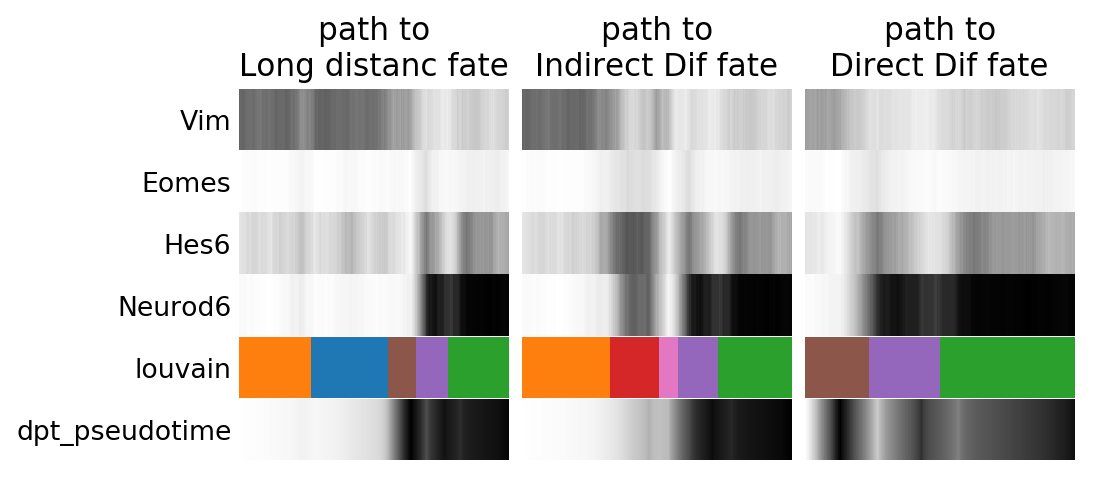

In [137]:
paths = [('Long distance', [1, 0, 5, 4, 2]),  # use the category indices instead of the cluster names
         ('Indirect Diff', [1, 3, 6, 4, 2]),
         ('Direct Diff',[5, 4, 2])]
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.11})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',                             
        title='path to\n{} fate'.format(descr[:-1]),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))

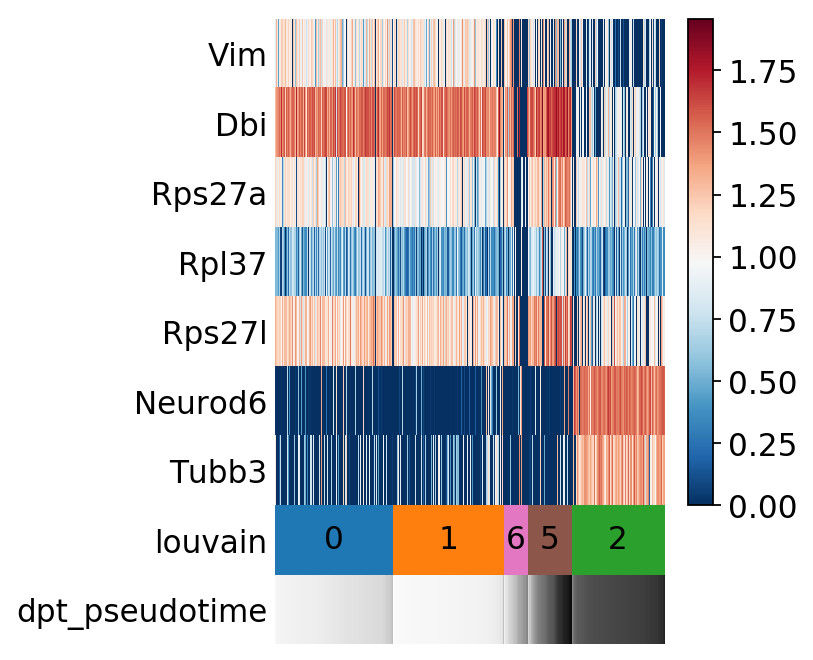

In [142]:
sc.pl.paga_path(adata, [0, 1, 6, 5, 2], ['Vim','Dbi','Rps27a','Rpl37','Rps27l','Neurod6','Tubb3'])